# Build models using vitals data

## Read data

In [1]:
import os
from pathlib import Path

import pandas as pd


dataDirName = Path(os.environ['DATA_DIR'], 'sepsis_prediction', 'lstm_initial_trials', '02_data_matrix', 'balanced_data')
dataDirName.mkdir(exist_ok=True, parents=True)

dataDf = pd.read_csv(Path(dataDirName, 'data.csv'))
dataDf = dataDf.sort_values(by=['PATIENT_ID', 'EPISODE_ID', 'measurement_datetime'], ascending=True)
dataDf

,PATIENT_ID,EPISODE_ID,measurement_datetime,Diastolic blood pressure_mean,Diastolic blood pressure_min,Diastolic blood pressure_max,Diastolic blood pressure_first,Diastolic blood pressure_last,Diastolic blood pressure_std,Heart rate_mean,...,Phosphate measurement_std,Magnesium measurement_mean,Magnesium measurement_min,Magnesium measurement_max,Magnesium measurement_first,Magnesium measurement_last,Magnesium measurement_std,Organism_FIRST_NOTED,sepsis,target
0,51211,17422049,2023-02-18,54.000000,54.000000,54.0,54.000000,54.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-04-01,0.0,0.0
1,51211,17422049,2023-02-19,54.000000,54.000000,54.0,54.000000,54.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-04-01,0.0,0.0
2,51211,17422049,2023-02-20,54.000000,54.000000,54.0,54.000000,54.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023-04-01,0.0,0.0
3,56089,14164983,2020-12-07,55.285714,39.000000,80.0,48.000000,51.000000,16.948100,79.000000,...,0.070711,0.767143,0.766667,0.767619,0.766667,0.767619,0.014142,2020-12-07,0.0,0.0
4,56089,14164983,2020-12-08,58.285714,34.000000,86.0,34.000000,70.000000,20.171880,70.833333,...,0.070711,0.810000,0.810000,0.810000,0.810000,0.810000,0.014142,2020-12-07,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231552,2662222,17201307,2022-12-30,58.647186,53.285714,66.0,59.285714,58.428571,5.213477,120.880000,...,0.234087,0.910000,0.910000,0.910000,0.910000,0.910000,0.108044,2022-12-21,0.0,0.0
231553,2662222,17201307,2022-12-31,58.647186,53.285714,66.0,59.285714,58.428571,5.213477,129.120000,...,0.183848,1.050000,1.010000,1.090000,1.090000,1.010000,0.056569,2022-12-21,0.0,0.0
231554,2662222,17201307,2023-01-01,58.647186,53.285714,66.0,59.285714,58.428571,5.213477,126.000000,...,0.234087,0.900000,0.900000,0.900000,0.900000,0.900000,0.108044,2022-12-21,0.0,0.0
231555,2662222,17201307,2023-01-02,58.647186,53.285714,66.0,59.285714,58.428571,5.213477,64.400000,...,0.234087,3.500000,3.500000,3.500000,3.500000,3.500000,0.108044,2022-12-21,0.0,0.0


In [2]:
dataDf.sepsis.value_counts()/dataDf.shape[0]

sepsis
1.0    0.912726
0.0    0.087274
Name: count, dtype: float64

In [3]:
dataDf.target.value_counts()/dataDf.shape[0]

target
0.0    0.544734
1.0    0.455266
Name: count, dtype: float64

In [5]:
rowsX = []
rowsY = []
for name, group in dataDf.groupby(by=['PATIENT_ID', 'EPISODE_ID']):
    low = 0
    high = 3
    while high <= group.shape[0]:
        valuesList = []
        for col in dataDf.columns[~dataDf.columns.isin(['PATIENT_ID', 'EPISODE_ID', 'measurement_datetime', 'Organism_FIRST_NOTED', 'sepsis', 'target'])]:
            valuesList.append(list(group[col][low: high]))
        rowsX.append(
            [[*x] for x in zip(*valuesList)]
            )
        rowsY.append(group.target[(high - 1): high].values[0])
        high += 1
        low += 1

In [6]:
import numpy as np


X = np.array(rowsX)
Y = np.array(rowsY)

In [7]:
X.shape, Y.shape

((225965, 3, 222), (225965,))

In [8]:
np.unique(Y, return_counts=True)[1]/Y.shape[0]

array([0.53638395, 0.46361605])

In [9]:
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((180772, 3, 222), (45193, 3, 222), (180772,), (45193,))

## LSTM using Pytorch

In [10]:
import torch
from torch import nn
import torch.utils.data as data

In [11]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

loader = data.DataLoader(data.TensorDataset(X_train_tensor, Y_train_tensor), shuffle=False, batch_size=1024)


In [12]:
print(X_train_tensor.shape, Y_train_tensor.shape, X_test_tensor.shape, Y_test_tensor.shape)

torch.Size([180772, 3, 222]) torch.Size([180772]) torch.Size([45193, 3, 222]) torch.Size([45193])


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [15]:
class LstmModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=222, hidden_size=1024, num_layers=1, batch_first=True)
        self.linear = nn.Linear(1024, 1)

    def forward(self, x):
        x, _ = self.lstm(x)          # -> (batch_size, seq_len, n_hidden)
        x = x[:, -1, :]
        x = self.linear(x)                  # -> (batch_size * seq_len, vocab_size)
        return x

In [16]:
model = LstmModel().to(device)
model

LstmModel(
  (lstm): LSTM(222, 1024, batch_first=True)
  (linear): Linear(in_features=1024, out_features=1, bias=True)
)

In [17]:
learning_rate = 0.001

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [18]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [19]:
# Number of epochs
epochs = 200

# Send data to the device
# x_train, x_valid = x_data.to(device), x_data.to(device)
# y_train, y_valid = y_data.to(device), y_data.to(device)

# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

# Loop through the data
for epoch in range(epochs):

    # Put the model in training mode
    model.train()

    for X_batch, y_batch in loader:
        y_logits = model(X_batch).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
        y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities

        # print(y_logits.shape, y_batch.shape)

        loss = loss_fn(y_logits, y_batch) # compute the loss
        acc = accuracy_fn(y_batch.int(), y_pred) # calculate the accuracy; convert the labels to integers

        optimizer.zero_grad() # reset the gradients so they don't accumulate each iteration
        loss.backward() # backward pass: backpropagate the prediction loss
        optimizer.step() # gradient descent: adjust the parameters by the gradients collected in the backward pass

    # Print progress a total of 20 times
    if epoch % int(epochs / 20) == 0:
        # Put the model in evaluation mode
        model.eval()

        with torch.inference_mode():
            y_logits = model(X_train_tensor).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities

            loss = loss_fn(y_logits, Y_train_tensor) # compute the loss
            acc = accuracy_fn(Y_train_tensor.int(), y_pred) # calculate the accuracy; convert the labels to integers

            valid_logits = model(X_test_tensor).squeeze()
            valid_pred = torch.round(torch.sigmoid(valid_logits))

            valid_loss = loss_fn(valid_logits, Y_test_tensor)
            valid_acc = accuracy_fn(Y_test_tensor.int(), valid_pred)
        
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        valid_loss_values.append(valid_loss.detach().numpy())

Epoch:    0 | Train Loss: 0.63223, Accuracy: 62.01% | Validation Loss: 0.63100, Accuracy: 61.97%
Epoch:   10 | Train Loss: 0.55498, Accuracy: 70.67% | Validation Loss: 0.62720, Accuracy: 62.96%
Epoch:   20 | Train Loss: 0.52684, Accuracy: 72.70% | Validation Loss: 0.62674, Accuracy: 63.37%
Epoch:   30 | Train Loss: 0.51354, Accuracy: 73.59% | Validation Loss: 0.62739, Accuracy: 64.11%
Epoch:   40 | Train Loss: 0.49525, Accuracy: 75.05% | Validation Loss: 0.62919, Accuracy: 64.39%
Epoch:   50 | Train Loss: 0.47676, Accuracy: 75.97% | Validation Loss: 0.63201, Accuracy: 64.17%


KeyboardInterrupt: 

In [20]:
y_batch.shape, y_batch.sum(), y_logits.shape, y_logits.sum(), y_pred.shape, y_pred.sum(), valid_logits.shape, valid_logits.sum(), valid_pred.shape, valid_pred.sum()

(torch.Size([1024]),
 tensor(690.),
 torch.Size([1024]),
 tensor(27.7731, grad_fn=<SumBackward0>),
 torch.Size([1024]),
 tensor(598., grad_fn=<SumBackward0>),
 torch.Size([45193]),
 tensor(-46847.9219),
 torch.Size([45193]),
 tensor(9348.))

In [21]:
Y_test.shape, Y_test.sum()

((45193,), np.float64(15801.0))

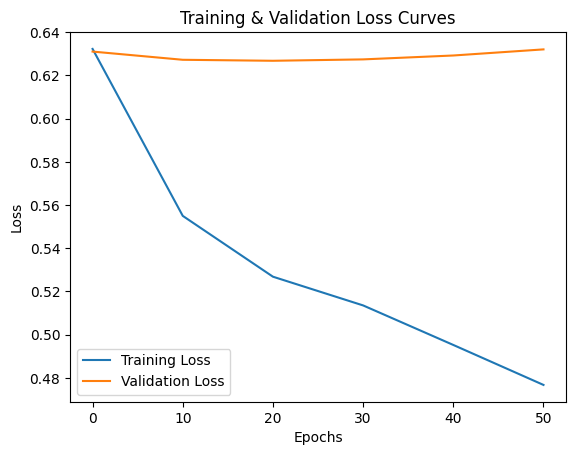

In [22]:
from matplotlib import pyplot as plt


plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import roc_auc_score


# y_logits = model(x_train).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels

print('roc_auc_score', roc_auc_score(Y_test, valid_logits.detach().numpy()))

roc_auc_score 0.6719635641983892


## DNN using Pytorch

In [24]:
import torch
from torch import nn

In [25]:
X_train_tensor = torch.tensor(X_train.reshape((X_train.shape[0], 666)), dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.reshape((X_test.shape[0], 666)), dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

In [26]:
X_train.shape

(180772, 3, 222)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [28]:
class DnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(666, 512)
        self.linear2 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.25)
    def forward(self, x):
        # return self.linear2(self.dropout(self.relu(self.linear1(x))))
        return self.linear2(self.relu(self.linear1(x)))

In [29]:
model = DnnModel().to(device)
model

DnnModel(
  (linear1): Linear(in_features=666, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)

In [30]:
learning_rate = 0.003

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

In [31]:
# Forward pass
logits = model(X_train_tensor)
logits

tensor([[-3.3851],
        [-8.5112],
        [-7.8007],
        ...,
        [ 4.3628],
        [ 4.3628],
        [ 4.3628]], grad_fn=<AddmmBackward0>)

In [32]:
pred_probab = torch.round(torch.sigmoid(logits))
pred_probab

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)

In [33]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

In [34]:
# Number of epochs
epochs = 5000

# Send data to the device
x_train, x_valid = X_train_tensor.to(device), X_test_tensor.to(device)
y_train, y_valid = Y_train_tensor.to(device), Y_test_tensor.to(device)

# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

# Loop through the data
for epoch in range(epochs):

    # Put the model in training mode
    model.train()

    y_logits = model(x_train).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
    y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities

    loss = loss_fn(y_logits, y_train) # compute the loss   
    acc = accuracy_fn(y_train.int(), y_pred) # calculate the accuracy; convert the labels to integers

    optimizer.zero_grad() # reset the gradients so they don't accumulate each iteration
    loss.backward() # backward pass: backpropagate the prediction loss
    optimizer.step() # gradient descent: adjust the parameters by the gradients collected in the backward pass
    
    # Put the model in evaluation mode
    model.eval() 

    with torch.inference_mode():
        valid_logits = model(x_valid).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_logits))    

        valid_loss = loss_fn(valid_logits, y_valid)
        valid_acc = accuracy_fn(y_valid.int(), valid_pred)    
    
    # Print progress a total of 20 times
    if epoch % int(epochs / 20) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        valid_loss_values.append(valid_loss.detach().numpy())

Epoch:    0 | Train Loss: 4.26703, Accuracy: 48.89% | Validation Loss: 215.90002, Accuracy: 65.04%
Epoch:  250 | Train Loss: 0.51154, Accuracy: 74.47% | Validation Loss: 0.66280, Accuracy: 64.47%
Epoch:  500 | Train Loss: 0.52273, Accuracy: 72.51% | Validation Loss: 0.68364, Accuracy: 64.36%
Epoch:  750 | Train Loss: 0.49958, Accuracy: 75.43% | Validation Loss: 0.67738, Accuracy: 63.36%
Epoch: 1000 | Train Loss: 0.46870, Accuracy: 77.25% | Validation Loss: 0.69826, Accuracy: 64.94%
Epoch: 1250 | Train Loss: 0.46588, Accuracy: 77.62% | Validation Loss: 0.69772, Accuracy: 63.72%
Epoch: 1500 | Train Loss: 0.47692, Accuracy: 76.55% | Validation Loss: 0.70406, Accuracy: 63.89%
Epoch: 1750 | Train Loss: 0.42796, Accuracy: 80.44% | Validation Loss: 0.72013, Accuracy: 63.72%


KeyboardInterrupt: 

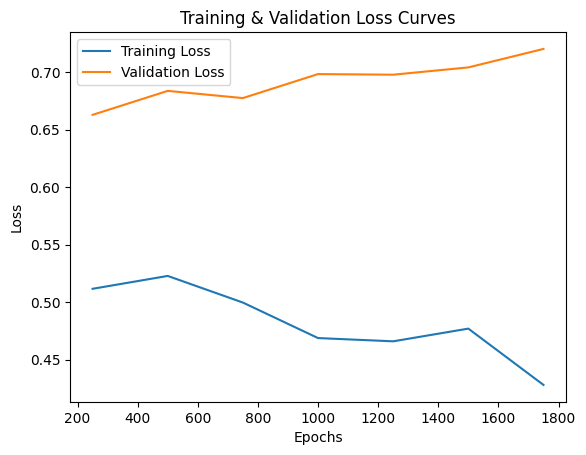

In [35]:
from matplotlib import pyplot as plt


plt.plot(epoch_count[1:], train_loss_values[1:], label='Training Loss')
plt.plot(epoch_count[1:], valid_loss_values[1:], label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score


y_logits = model(X_test_tensor).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels

print('roc_auc_score', roc_auc_score(Y_test_tensor, y_logits.detach().numpy()))

roc_auc_score 0.6773967825003806


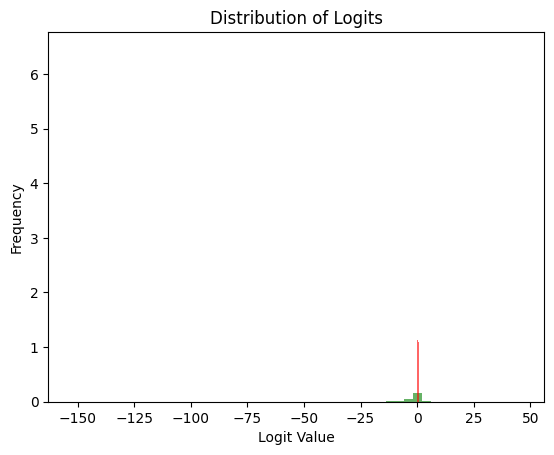

In [37]:
y_logits = model(x_train).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
    # y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities
# Create the histogram
plt.hist(y_logits.detach().numpy(), bins=50, density=True, alpha=0.6, color='g')
plt.hist(torch.sigmoid(y_logits).detach().numpy(), bins=50, density=True, alpha=0.6, color='r')

# Add labels and title
plt.xlabel('Logit Value')
plt.ylabel('Frequency')
plt.title('Distribution of Logits')

# Display the plot
plt.show()

## Traditional ML

### NB Classifier model

In [38]:
from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
y_score = gnb.fit(X_train.reshape((X_train.shape[0], 666)), Y_train).predict_proba(X_test.reshape((X_test.shape[0], 666)))
y_pred = gnb.fit(X_train.reshape((X_train.shape[0], 666)), Y_train).predict(X_test.reshape((X_test.shape[0], 666)))


In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print('Accuracy', accuracy_score(Y_test, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(Y_test, y_pred))
print('F1 Score', f1_score(Y_test, y_pred))
print('Precision Score', precision_score(Y_test, y_pred))
print('Recall Score', recall_score(Y_test, y_pred))
print('roc_auc_score', roc_auc_score(Y_test, [y[1] for y in y_score]))

Accuracy 0.44562210961874626
Balanced Accuracy 0.5542909544409463
F1 Score 0.5359511020559363
Precision Score 0.37885254916337163
Recall Score 0.9156382507436238
roc_auc_score 0.5751964978081878


### LR Classifier

In [40]:
from sklearn.linear_model import LogisticRegression


lrc = LogisticRegression(random_state=0)
y_score = lrc.fit(X_train.reshape((X_train.shape[0], 666)), Y_train).predict_proba(X_test.reshape((X_test.shape[0], 666)))
y_pred = lrc.fit(X_train.reshape((X_train.shape[0], 666)), Y_train).predict(X_test.reshape((X_test.shape[0], 666)))

/home/vmadmin/workspace/sepsis_predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vmadmin/workspace/sepsis_predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print('Accuracy', accuracy_score(Y_test, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(Y_test, y_pred))
print('F1 Score', f1_score(Y_test, y_pred))
print('Precision Score', precision_score(Y_test, y_pred))
print('Recall Score', recall_score(Y_test, y_pred))
print('roc_auc_score', roc_auc_score(Y_test, [y[1] for y in y_score]))

Accuracy 0.6157369504126745
Balanced Accuracy 0.6043786156909303
F1 Score 0.5076547970061238
Precision Score 0.4598120281444199
Recall Score 0.5666097082463135
roc_auc_score 0.63911794875134


### XGBoost Classifier

In [42]:
from xgboost import XGBClassifier

bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train.reshape((X_train.shape[0], 666)), Y_train)
# make predictions
y_score = bst.predict_proba(X_test.reshape((X_test.shape[0], 666)))
y_pred = bst.predict(X_test.reshape((X_test.shape[0], 666)))

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print('Accuracy', accuracy_score(Y_test, y_pred))
print('Balanced Accuracy', balanced_accuracy_score(Y_test, y_pred))
print('F1 Score', f1_score(Y_test, y_pred))
print('Precision Score', precision_score(Y_test, y_pred))
print('Recall Score', recall_score(Y_test, y_pred))
print('roc_auc_score', roc_auc_score(Y_test, [y[1] for y in y_score]))

Accuracy 0.6664085145929679
Balanced Accuracy 0.6285270734399816
F1 Score 0.5130176367982427
Precision Score 0.5239163422840931
Recall Score 0.5025631289158914
roc_auc_score 0.673326210990002
